# Collaborative Filtering: Matrix Factorization Recommender System

## Netflix Recommender Model

### Basics of The Recommender System
> The reason why consumers need reliable recommendations is straightforward: Given the availability of almost unlimited number of choices (e.g. different movie genres of various quality), and the natural tendency of human is to maximize his/her utility, the user needs guidance to the next best item that accommodates his/her needs or preferences. Specifically, Netflix has become so popular because of its capability to suggest the user a next movie (from thousands of other options) that matches to the best of user's taste.

### Types of the Systems
- There are many ways and complex algorithms used to build a recommender system. The following are fundamental approaches. While reading, the reader should think which one may be the most effective method when it comes to a movie recommendation.

- >The Most Popular Item: It is the simplest strategy and requires no coding skills. It works based on the assumption that the most popular item attracts most consumers or most users. For example, any consumer shopping on Amazon would see the most frequently bought items. Conversely, Netflix would recommend every user the most popular movie in its list.

- >Association & Market Based Model: The system makes recommendations based on the items in the consumer's basket. For instance, if the system detected that the buyer is purchasing ground coffee it would also suggest her to buy filters as well (observed association coffee - filters).

- >Content Filtering: Uses metadata to determine the user's taste. For example, the system recommends the user movies based on their preferences of genres, actors, themes, etc. Such a system matches the user and the item based on similarity. For example, if the user watched and liked Terminator and Predator (both action movies with Arnold Schwarzenegger in the main role), it would probably recommend them to watch Commando.

- >User-based (UBCF): It is a predecessor of Item-based CF. UBCF makes recommendations based on the user's characteristics that are similar to other users in the system. For example, if the end-user positively rates a movie, the algorithm finds other users who have previously rated the movie too, i.e. these users are similar to one another. In the next step, the system recommends the user an unseen movie but highly rated by other - referenced - users. See Figure 1.

- >Item-based (IBCF): IBCF was originally developed by Amazon and is currently adopted by most online corporations (e.g. Netflix, YouTube, etc.).

- >Hybrid Models: As the name suggests, the Hybrid Models combine two or more recommendation strategies. For instance, a Hybrid Content-Collaborative System can recommend the user a movie based on their gender but still focuses on the movie features the user exhibits to prefer.

- Netflix's recommendation engine is based on the assumption that similar users like and dislike similar items; i.e. Collaborative Filtering is the key to Netflix's success

Issues with UBCF
Even though CF is powerful, there are few challenges. Like other researchers, Sarwar et al. (2001) state that scalability and sparsity are the primary issues.

Scalability: In a system where there are many new users, i.e. users with low records of ratings, it is computationally expensive to train the model. A typical example would be a web-based application with a recommender system incorporating millions of users and items. Such problems arise with Nearest Neighbour algorithms in UBCF where such algorithms require computations that grow simultaneously with the increasing numbers of users and items.

Sparsity arises in a system when even the most active users have rated or purchased only a marginal number of available items. For example, these users may have experience with even less than 1% of available items.

If a recommender system experiences either one or both of the described issues, the algorithm's performance decreases; i.e. the system does not recommend the user relevant items (Sarwar et al.,2001). Consequently, the user does not trust the recommendations.

### 1. Load Packages 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

np.random.seed(42)
seed = 42

In [97]:
path = 'C:\\Users\\bokhy\\Desktop\\Python\\Python-Projects'
df = pd.read_csv(os.path.join(path, 'data_final.csv'), engine = 'python')
print('Columns of movies_df: {0}'.format(df.columns))

Columns of movies_df: Index(['Unnamed: 0', 'machine_uuid', 'Email', 'Game', 'activity.play_duration',
       'Platform', 'State', 'geoip.city_name', 'activity.display_firmware',
       'geoip.timezone', 'date', 'Time', 'year', 'month', 'hour', 'Weekdays',
       'timeoftheday'],
      dtype='object')


## 2. Data Pre-Processing / Loading

- All selected users have played at least 5 titles in the data set (remove some of the noise from outliers)
- However, the following code filters out the movies and users based on an arbitrary threshold and creates a new data frame ratings_flrd_df. Moreover, the chunk also prints the value of deleted movies with new and old dimensions.

### give ratings 1-10 based on playtime

In [98]:
df['activity.play_duration'] = df['activity.play_duration']*3600
df['activity.play_duration'] = df['activity.play_duration'].apply(pd.to_numeric, errors='coerce')

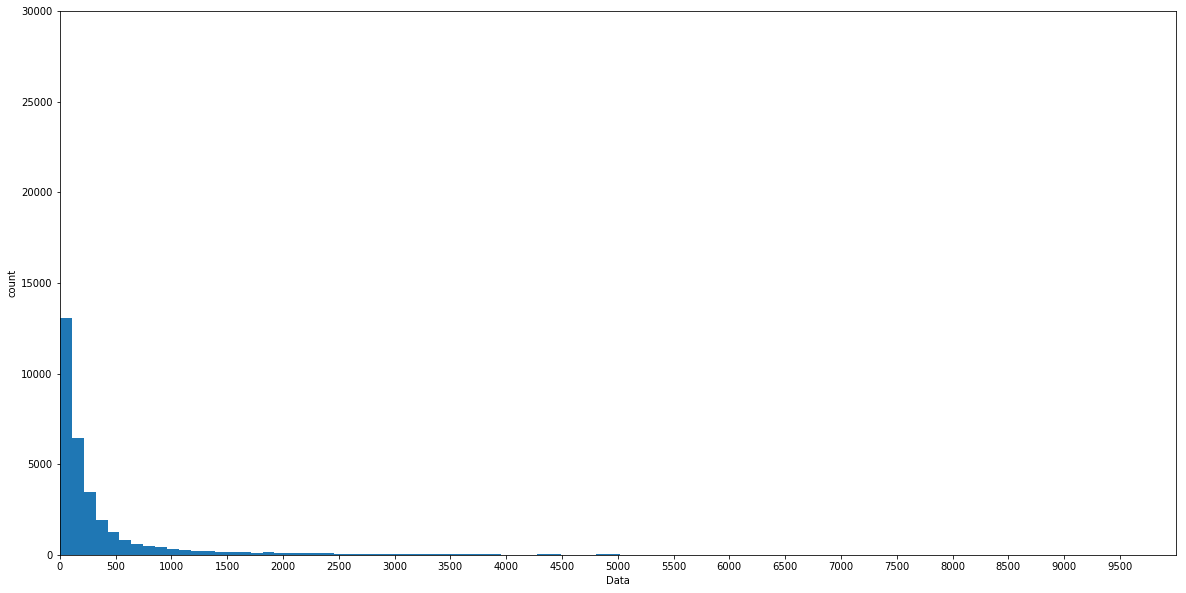

In [99]:
plt.figure(figsize=(20,10))
plt.hist(df['activity.play_duration'], density=False, bins=400)  # `density=False` would make counts
plt.axis([0,10000, 0, 30000]) 
#axis([xmin,xmax,ymin,ymax])
x_ticks = np.arange(0, 10000, 500)
plt.xticks(x_ticks)
plt.ylabel('count')
plt.xlabel('Data');

In [100]:
def label_race(row):
    if (row['activity.play_duration'] >= 0) & (row['activity.play_duration'] < 360):
        return 0
    if (row['activity.play_duration'] >= 361) & (row['activity.play_duration'] < 720) :
        return 1
    if (row['activity.play_duration'] >= 721) & (row['activity.play_duration'] < 1080) :
        return 2
    if (row['activity.play_duration'] >= 1081) & (row['activity.play_duration'] < 1440) :
        return 3
    if (row['activity.play_duration'] >= 1441) & (row['activity.play_duration'] < 1800) :
        return 4
    if (row['activity.play_duration'] >= 1801) & (row['activity.play_duration'] < 2160) :
        return 5
    if (row['activity.play_duration'] >= 2161) & (row['activity.play_duration'] < 2520) :
        return 6
    if (row['activity.play_duration'] >= 2521) & (row['activity.play_duration'] < 2880) :
        return 7
    if (row['activity.play_duration'] >= 2881) & (row['activity.play_duration'] < 3240) :
        return 8
    if (row['activity.play_duration'] >= 3241) & (row['activity.play_duration'] < 3600) :
        return 9    
    return 10

In [101]:
df['eventStrength'] = df.apply(lambda row: label_race(row), axis=1)

- For each log, we associate them with a different weight or strength, assuming that, for example, 
a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [102]:
users_interactions_count_df = df.groupby(['machine_uuid', 'Game']).size().groupby('machine_uuid').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['machine_uuid']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1102
# users with at least 5 interactions: 697


In [103]:
print('# of interactions: %d' % len(df))
interactions_from_selected_users_df = df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'machine_uuid',
               right_on = 'machine_uuid')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 31902
# of interactions from users with at least 5 interactions: 29734


- Users are allowed to play games many times. Thus, to model the user interest on a given article, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [104]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['machine_uuid', 'Game'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df['eventStrength'] = interactions_full_df['eventStrength'].astype('float64') 
interactions_full_df.head()

# of unique user/item interactions: 13291


,machine_uuid,Game,eventStrength
0,88001908A0000910,3-D Tic-Tac-Toe (2600),0.0
1,88001908A0000910,64th Street - A Detective Story,0.0
2,88001908A0000910,Basketball (2600),0.0
3,88001908A0000910,Big Run,0.0
4,88001908A0000910,Fix-It Felix Jr.,1.0


In [106]:
interactions_full_df.to_csv('interactions_full_df.csv', index=False)

# Evaluation

In [10]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                                               stratify=interactions_full_df['machine_uuid'], 
                                                               test_size=0.2,
                                                               random_state=623)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 10632
# interactions on Test set: 2659


- Evaluation is important for machine learning projects, because it allows to compare objectivelly different algorithms and hyperparameter choices for models.
- One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using Cross-validation techniques. We are using here a simple cross-validation approach named holdout, in which a random data sample (20% in this case) are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the test set.

- Ps. A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this notebook, but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

- In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.
This evaluation method works as follows:

- For each user
>- For each item the user has interacted in test set
  >- Sample 100 other items the user has never interacted.
    >- Ps. Here we naively assume those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption.
    >- Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted ("non-relevant!) items
    >- Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
    >- Aggregate the global Top-N accuracy metrics
    
> The Top-N accuracy metric choosen was Recall@N which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.

In [11]:
#Indexing by machineID to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('machine_uuid')
interactions_train_indexed_df = interactions_train_df.set_index('machine_uuid')
interactions_test_indexed_df = interactions_test_df.set_index('machine_uuid')

In [12]:
def get_items_interacted(machine_uuid, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[machine_uuid]['Game']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [13]:
# sample game title
interactions_test_indexed_df.loc['88001908A0000910']['Game']

'Basketball (2600)'

In [73]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 10

class ModelEvaluator:


    def get_not_interacted_items_sample(self, machine_uuid, sample_size, seed=42):
        interacted_items = get_items_interacted(machine_uuid, interactions_full_indexed_df)
        all_items = set(df['Game'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, machine_uuid):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[machine_uuid]
        if type(interacted_values_testset['Game']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['Game'])
        else:
            person_interacted_items_testset = set(interacted_values_testset['Game'])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(machine_uuid, 
                                               items_to_ignore=get_items_interacted(machine_uuid, 
                                                                                    interactions_train_indexed_df), 
                                               topn=1000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (5) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(machine_uuid, 
                                                                               sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=42)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['Game'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['Game'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, machine_uuid in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, machine_uuid)  
            person_metrics['_machine_uuid'] = machine_uuid
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

## 1. Popularity model

- simply recommends to a user the most popular items that the user has not previously consumed

In [74]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('Game')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head()

,Game,eventStrength
0,Centipede® (Arcade),843.609910
1,Fix-It Felix Jr.,643.227683
2,BurgerTime??(Arcade),617.466756
3,Tetris®,432.876168
4,Tron,400.187357


In [75]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['Game'].isin(items_to_ignore)].sort_values('eventStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Game', 
                                                          right_on = 'Game')[['eventStrength', 'Game']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df)

In [77]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
696 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.49923497267759565, 'recall@10': 0.546448087431694}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_machine_uuid
7,42,43,43,0.976744,1.0,88001912B00093D0
79,35,43,43,0.813953,1.0,88001908A0069438
14,24,25,25,0.960000,1.0,88001908A04601E0
683,0,0,21,0.000000,0.0,88001908A0121348
142,0,0,21,0.000000,0.0,88001908A0389928
657,0,0,21,0.000000,0.0,88001908A05528A8
563,0,0,21,0.000000,0.0,88001908A03035E0
639,0,0,20,0.000000,0.0,88001910B0000888
271,20,20,20,1.000000,1.0,88001908A0095970
38,19,20,20,0.950000,1.0,88001908A03882F8


## 2.Collaborative Filtering model

- leverage description or attributes from items the user has interacted to recommend similar items. It depends only on the user previous choices, making this method robust to avoid the cold-start problem. For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles.

- Here we are using a very popular technique in information retrieval (search engines) named TF-IDF. This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article

- Memory-based: This approach uses the memory of previous users interactions to compute users similarities based on items they've interacted (user-based approach) or compute items similarities based on the users that have interacted with them (item-based approach).
> A typical example of this approach is User Neighbourhood-based CF, in which the top-N similar users (usually computed using Pearson correlation) for a user are selected and used to recommend items those similar users liked, but the current user have not interacted yet. This approach is very simple to implement, but usually do not scale well for many users. A nice Python implementation of this approach in available in Crab.

- Model-based: This approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like neural networks, bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SVD) and, probabilistic latent semantic analysis.

### Matrix Factorization

- Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.

- A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.

- Here we a use popular latent factor model named Singular Value Decomposition (SVD)
- https://en.wikipedia.org/wiki/Singular_value_decomposition

- An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

In [78]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='machine_uuid', 
                                                          columns='Game', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

Game,3-D Tic-Tac-Toe (2600),64th Street - A Detective Story,8 Eyes,ART OF FIGHTING 2,ARTS-TOWER,Act-Fancer Cybernetick Hyper Weapon,Adventure (2600),Adventure II (2600),Air Cavalry,Air-Sea Battle (2600),...,jzmain,krylz3-mars,lt2-edev,main,misty,orion,owner,poowhistles,rbowden,showtime is best
machine_uuid,,,,,,,,,,,,,,,,,,,,,
88001908A0000910,1.0,1.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88001908A00010A8,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88001908A00012C0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88001908A00017C8,0.0,1.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88001908A00027E0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88001908A0007120,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88001908A00081A8,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88001908A0009810,0.0,0.0,0.0,3.70044,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88001908A0011980,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,2.807355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['88001908A0000910',
 '88001908A00010A8',
 '88001908A00012C0',
 '88001908A00017C8',
 '88001908A00027E0',
 '88001908A0007120',
 '88001908A00081A8',
 '88001908A0009810',
 '88001908A0011980',
 '88001908A0015490']

In [81]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<697x481 sparse matrix of type '<class 'numpy.float64'>'
	with 10632 stored elements in Compressed Sparse Row format>

In [82]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 25
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [83]:
U.shape

(697, 25)

In [84]:
sigma = np.diag(sigma)
sigma.shape

(25, 25)

In [85]:
Vt.shape

(25, 481)

- After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [86]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 7.96947536e-02,  9.90149301e-01,  8.80994011e-02, ...,
        -4.74300731e-03, -1.68860884e-02, -3.29838755e-04],
       [-4.51442033e-04,  4.33180887e-02, -9.61015396e-03, ...,
         2.20047858e-03,  1.96956728e-02,  1.84427473e-03],
       [ 4.16232449e-02, -4.69834786e-03,  5.34394134e-02, ...,
         1.72254836e-02,  1.31021138e-02,  3.23075492e-04],
       ...,
       [-3.45797573e-02,  1.23847867e-01,  2.85533561e-02, ...,
        -1.05366199e-02,  2.19477041e-02, -2.86542333e-03],
       [ 1.30442246e-02,  1.21787204e-01, -4.30568483e-02, ...,
        -3.89209511e-03,  1.84580222e-02,  8.96373610e-04],
       [ 9.93599917e-02, -9.90343437e-02,  8.33598128e-02, ...,
         6.67514757e-03, -2.55405373e-02, -2.42872730e-03]])

In [87]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [88]:
#Convert reconstructed matrix to dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,88001908A0000910,88001908A00010A8,88001908A00012C0,88001908A00017C8,88001908A00027E0,88001908A0007120,88001908A00081A8,88001908A0009810,88001908A0011980,88001908A0015490,...,88001912B0171030,88001912B0176210,88001912B01769D8,88001912B01774B0,880019PPA0004158,88002002B00001C0,88002002B00069E8,88002002B00080D8,88002002B00087B8,88002002B00098B8
Game,,,,,,,,,,,,,,,,,,,,,
3-D Tic-Tac-Toe (2600),0.224455,0.217191,0.221004,0.234721,0.230746,0.218288,0.225084,0.229515,0.233847,0.216625,...,0.222432,0.229216,0.213741,0.254047,0.238223,0.226667,0.230760,0.214097,0.218414,0.226237
64th Street - A Detective Story,0.306975,0.221158,0.216806,0.303998,0.215031,0.219848,0.239975,0.262446,0.246601,0.226521,...,0.216970,0.220747,0.220319,0.226617,0.240760,0.289277,0.422385,0.228457,0.228270,0.208256
8 Eyes,0.225217,0.216361,0.222075,0.222273,0.216639,0.215985,0.236505,0.225443,0.222624,0.216673,...,0.217828,0.222575,0.216088,0.227764,0.235469,0.225566,0.246759,0.219820,0.213329,0.224787
ART OF FIGHTING 2,0.217635,0.218602,0.225729,0.221737,0.211763,0.218159,0.206993,0.265739,0.211113,0.216257,...,0.219025,0.213900,0.220704,0.219657,0.223215,0.218289,0.248402,0.234852,0.219492,0.218010
ARTS-TOWER,0.216521,0.216349,0.217243,0.220297,0.219193,0.217582,0.227639,0.215822,0.218320,0.217609,...,0.218059,0.222169,0.216197,0.220762,0.216758,0.216227,0.217035,0.215783,0.217413,0.220815


In [89]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['Game'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Game', 
                                                          right_on = 'Game')[['recStrength', 'Game']]
        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df)

In [90]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
696 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.40502732240437156, 'recall@10': 0.5320218579234973}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_machine_uuid
7,42,42,43,0.976744,0.976744,88001912B00093D0
79,38,42,43,0.883721,0.976744,88001908A0069438
14,22,25,25,0.880000,1.000000,88001908A04601E0
683,0,0,21,0.000000,0.000000,88001908A0121348
142,0,0,21,0.000000,0.000000,88001908A0389928
657,0,0,21,0.000000,0.000000,88001908A05528A8
563,0,0,21,0.000000,0.000000,88001908A03035E0
639,0,0,20,0.000000,0.000000,88001910B0000888
271,17,20,20,0.850000,1.000000,88001908A0095970
38,17,18,20,0.850000,0.900000,88001908A03882F8


# 3. Compare Models

In [91]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.499235,0.546448
Collaborative Filtering,0.405027,0.532022


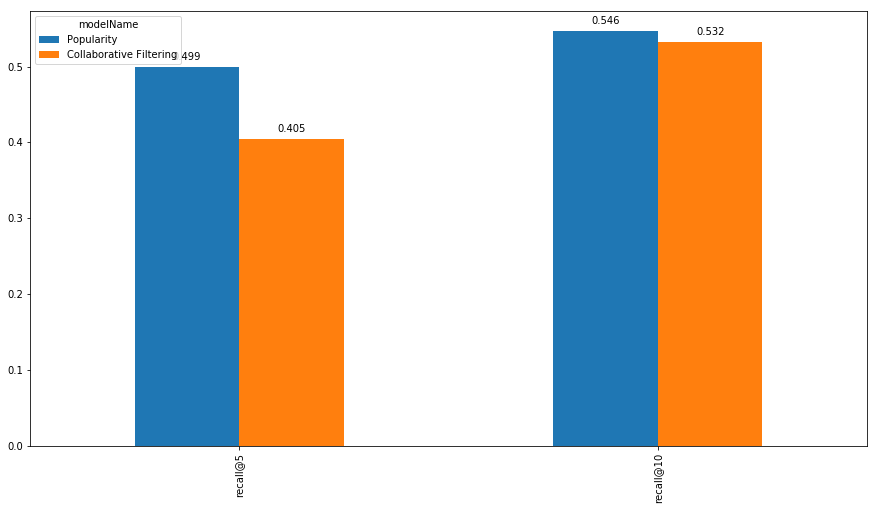

In [92]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

## 4. Testing

In [96]:
cf_recommender_model.recommend_items('88001908A00017C8', topn=5, verbose=False)

,Game,recStrength
0,Asteroids® (Arcade),0.577550
1,BurgerTime??(Arcade),0.435864
2,Tempest® (Arcade),0.432169
3,Asteroids® Deluxe (Arcade),0.380093
4,Missile Command® (Arcade),0.372521


In [95]:
popularity_model.recommend_items('88001908A00017C8', topn=10, verbose=False)

,Game,eventStrength
0,Centipede® (Arcade),843.609910
1,Fix-It Felix Jr.,643.227683
2,BurgerTime??(Arcade),617.466756
3,Tetris®,432.876168
4,Tron,400.187357
5,Tempest® (Arcade),393.066848
6,Asteroids® (Arcade),391.680449
7,64th Street - A Detective Story,350.610033
8,Aladdin,319.033232
9,Crystal Castles® (Arcade),280.821674


- From https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101

- Addition https://github.com/jiristo/recsys_matrixfactorization/blob/master/recsys.ipynb